**Acknowledgements:**

The codes are taken from [Idiot Developer](https://www.youtube.com/watch?v=LkmgdNpcgTM&t=841s) watch the videos for detailed explanation.

In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

def convolution_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = convolution_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = convolution_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = convolution_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

if __name__ == "__main__":
    input_shape = (512, 512, 3)
    
    model = build_unet(input_shape)
    #model.summary()

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
from lung_seg_model import build_unet
from lung_seg_metrics import dice_loss, dice_coef, iou
from tensorflow.keras.utils import CustomObjectScope

In [ ]:
""" Global parameters """
H = 512
W = 512


In [ ]:
def create_dir(path):
    """ Create a directory. """
    if not os.path.exists(path):
        os.makedirs(path)

In [ ]:
def load_data(path):
    train_x = sorted(glob(os.path.join(path,"Train", "CXR_png", "*.png")))
    train_y1= sorted(glob(os.path.join(path,"Train", "ManualMask", "leftMask", "*.png")))
    train_y2= sorted(glob(os.path.join(path,"Train", "ManualMask", "rightMask", "*.png")))

    valid_x = sorted(glob(os.path.join(path,"Valid", "CXR_png", "*.png")))
    valid_y1= sorted(glob(os.path.join(path,"Valid", "ManualMask", "leftMask", "*.png")))
    valid_y2= sorted(glob(os.path.join(path,"Valid", "ManualMask", "rightMask", "*.png")))

    return (train_x, train_y1, train_y2), (valid_x, valid_y1, valid_y2)

In [ ]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    return x

In [ ]:
def read_mask(path1, path2):
    x1 = cv2.imread(path1, cv2.IMREAD_GRAYSCALE)
    x2 = cv2.imread(path2, cv2.IMREAD_GRAYSCALE)
    x = x1 + x2
    x = cv2.resize(x, (W, H))
    x = x/np.max(x)
    x = x > 0.5
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

In [ ]:

def tf_parse(x, y1, y2):
    def _parse(x, y1, y2):
        x = x.decode()
        y1 = y1.decode()
        y2 = y2.decode()

        x = read_image(x)
        y = read_mask(y1, y2)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y1, y2], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

In [ ]:
def tf_dataset(X, Y1, Y2, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y1, Y2))
    dataset = dataset.shuffle(buffer_size=200)
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(4)
    return dataset

In [ ]:
if __name__ == "__main__":
    """ Directory for storing files """
    create_dir("files")

    """ Hyperparameters """
    batch_size = 2
    lr = 1e-5             #this is the learning rate alpha
    num_epochs = 10
    model_path = os.path.join("files", "model.h5")
    csv_path = os.path.join("files", "data.csv")

    """ Dataset """
    dataset_path = "/content/drive/MyDrive/Colab Notebooks/CustomMontgomerySet"
    (train_x, train_y1, train_y2), (valid_x, valid_y1, valid_y2)= load_data(dataset_path)
     
   #  here we are printing to see that train x, train y1 and train y2  have same number of images. 
    print(f"Train: {len(train_x)} - {len(train_y1)} - {len(train_y2)}")
    print(f"Valid: {len(valid_x)} - {len(valid_y1)} - {len(valid_y2)}")
    
    
    """Lets find the train and valid dataset using the tf_dataset function and the batchsize is 2"""
    train_dataset = tf_dataset(train_x, train_y1, train_y2, batch=batch_size)
    valid_dataset = tf_dataset(valid_x, valid_y1, valid_y2, batch=batch_size)
  

    
    """ Model """
    model = build_unet((H, W, 3))
    metrics = [dice_coef, iou, Recall(), Precision()]
    model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=metrics)
    

    callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path)
    ]

    model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=valid_dataset,
        callbacks=callbacks
    )


Train: 118 - 118 - 118
Valid: 10 - 10 - 10
Epoch 1/10
59/59 [==============================] - ETA: 0s - loss: 0.5048 - dice_coef: 0.4952 - iou: 0.3331 - recall: 0.8744 - precision: 0.4750
Epoch 1: val_loss improved from inf to 0.65479, saving model to files/model.h5
59/59 [==============================] - 263s 4s/step - loss: 0.5048 - dice_coef: 0.4952 - iou: 0.3331 - recall: 0.8744 - precision: 0.4750 - val_loss: 0.6548 - val_dice_coef: 0.3452 - val_iou: 0.2090 - val_recall: 0.9655 - val_precision: 0.3160 - lr: 1.0000e-05
Epoch 2/10
59/59 [==============================] - ETA: 0s - loss: 0.3538 - dice_coef: 0.6462 - iou: 0.4792 - recall: 0.9258 - precision: 0.5911
Epoch 2: val_loss improved from 0.65479 to 0.64129, saving model to files/model.h5
59/59 [==============================] - 51s 857ms/step - loss: 0.3538 - dice_coef: 0.6462 - iou: 0.4792 - recall: 0.9258 - precision: 0.5911 - val_loss: 0.6413 - val_dice_coef: 0.3587 - val_iou: 0.2207 - val_recall: 0.9018 - val_precision:

Testing the images in the test folder

In [ ]:
if __name__ == "__main__":
   
    """ Directory for storing files """
    create_dir("results")

    """ Loading model """
    with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss}):
        model = tf.keras.models.load_model("files/model.h5")

    """ Dataset """
    path = "/content/drive/MyDrive/Colab Notebooks/CustomMontgomerySet/Test/CXR_png"
    test_x= sorted(glob(os.path.join(path, "*.png")))

    print(len(test_x))

    for x in tqdm(test_x, total=len(test_x)):
      """Extracting the image name"""
      image_name = x.split("/")[-1]


      """Reading the image"""
      ori_x=cv2.imread(x,cv2.IMREAD_COLOR)
      ori_x = cv2.resize(ori_x, (W, H))
      x = ori_x/255.0
      x = x.astype(np.float32)
      x = np.expand_dims(x, axis=0)

      """ Predicting the mask. """
      y_pred = model.predict(x)[0] > 0.5
      y_pred = y_pred.astype(np.int32)

      """ Saving the predicted mask along with the image and GT """
      save_image_path = f"/content/drive/MyDrive/Colab Notebooks/Results/{image_name}"
      y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)

      sep_line = np.ones((H, 10, 3)) * 255
      cat_image = np.concatenate([ori_x,sep_line,y_pred*255], axis=1)
      cv2.imwrite(save_image_path, cat_image)
       
     

        

12


100%|██████████| 12/12 [00:28<00:00,  2.36s/it]


Testing custom images 

In [ ]:
if __name__ == "__main__":

    """ Loading model """
    with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss}):
        model = tf.keras.models.load_model("files/model.h5")

    img=cv2.imread("12.jpeg",cv2.IMREAD_COLOR)
    img = cv2.resize(img, (W, H))
    x = img/255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=0)

    y_pred = model.predict(x)[0] > 0.5
    y_pred = y_pred.astype(np.int32)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)

    sep_line = np.ones((H, 10, 3)) * 255
    output_image = np.concatenate([img,sep_line,y_pred*255], axis=1)
    cv2.imwrite("Output_img3.jpeg", output_image)



    

**Output image**

input-ground truth-output

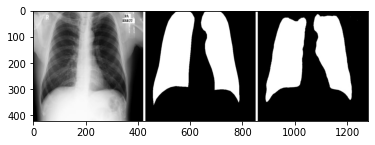

In [1]:
import cv2
import matplotlib.pyplot as plt

x=cv2.imread("img.jpeg")
x=cv2.cvtColor(x, cv2.COLOR_RGB2BGR)
plt.imshow(x)